In [16]:
#Import statements
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import re
from datetime import date
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

In [9]:
#Load the data
filenameMembers = "115Congress.csv"
names = pd.read_csv(filenameMembers,encoding='utf-8')
firstNames = []
lastNames = []
fileNameState = "stateDecoder.csv"
stateCode = pd.read_csv(fileNameState,encoding='utf-8')
fileNamePD = "partisanDistricts.csv"
partisanDistricts = pd.read_csv(fileNamePD,encoding='latin_1')
fileNamePS = "partisanStates.csv"
partisanStates = pd.read_csv(fileNamePS,encoding='latin_1')
values = []
#Get info about what district each member is from and what their Cook PVI is
for _, row in names.iterrows():
    name = row["Name"]
    parts = name.split(", ")
    lastName = parts[0]
    firstName = parts[1].split(" ")[0]
    initial = lastName[0]
    fullState = row["State Label"]
    potentialState = stateCode[stateCode["State"] == fullState]["Code"].values
    if len(potentialState)>0:
        stateID = potentialState[0]
    else:
        continue
    district = int(row["District"])
    
    if district == 0:
        if row["Chamber"] == "Representative":
            distID = "AL"
        else:
            distID = "Sen"
    elif district < 10:
        distID = "0"+str(district)
    else:
        distID = str(district)
    
    if distID == "Sen" or stateID == "DC":
        pvi = partisanStates[partisanStates["State"]==fullState]["PVI"].values[0]
    else:
        pvi = partisanDistricts[partisanDistricts["Dist"]==stateID+"-"+distID]["PVI"].values[0]
    if pvi[0]=="R":
        convPVI = int(pvi[2:])
    elif pvi[0] == "D":
        convPVI = -int(pvi[2:])
    else:
        convPVI = 0
    value = [lastName, firstName, initial, stateID, distID, convPVI]
    values.append(value)
newNames = pd.DataFrame(values, columns=["lastName","firstName","lastInitial","State","District","PVI"])

In [10]:
#Read in the newsletter data
fileNames = ["115Congress_newsletter/02_2017.csv",
             "115Congress_newsletter/03_2017.csv",
             "115Congress_newsletter/04_2017.csv",
             "115Congress_newsletter/05_2017.csv",
             "115Congress_newsletter/06_2017.csv",
             "115Congress_newsletter/07_2017.csv",
             "115Congress_newsletter/08_2017.csv",
             "115Congress_newsletter/09_2017.csv",
             "115Congress_newsletter/10_2017.csv",
             "115Congress_newsletter/11_2017.csv",
             "115Congress_newsletter/12_2017.csv",
             "115Congress_newsletter/01_2018.csv",
             "115Congress_newsletter/02_2018.csv",
             "115Congress_newsletter/03_2018.csv",
             "115Congress_newsletter/04_2018.csv",
             "115Congress_newsletter/05_2018.csv",
             "115Congress_newsletter/06_2018.csv",
             "115Congress_newsletter/07_2018.csv",
             "115Congress_newsletter/08_2018.csv",
             "115Congress_newsletter/09_2018.csv",
             "115Congress_newsletter/10_2018.csv",
             "115Congress_newsletter/11_2018.csv",
             "115Congress_newsletter/12_2018.csv"
            ]
data = pd.read_csv(fileNames[0])

data["Date"] = date(int(fileNames[0][-8:-4]),int(fileNames[0][-11:-9]),1)
for fileName in fileNames[1:]:
    temp = pd.read_csv(fileName)
    temp["Date"] = date(int(fileName[-8:-4]),int(fileName[-11:-9]),1)
    data = data.append(temp)

In [11]:
#These newsletters aren't lebelled with who sent them, so this performs a search to discover that
def findAuth(subj, text,init):
    if type(text) != str:
        return "idk"
    possAuths = newNames[newNames["lastInitial"]==init]["lastName"].values
    poss = []
    #First search their last name in the subject and then body. We know their last name has to 
    #Start with the first letter of the bioguide_id 
    for auth in possAuths:
        search = re.compile(r"""(\s|,|\.)(%s).?(\s|,|\.|\))""" % auth)
        occurrences = search.subn("", subj)[1]
        if occurrences > 0:
            poss.append(auth)
            continue
        search = re.compile(r"""(\s|,|\.)(%s).?(\s|,|\.|\))""" % auth)
        occurrences = search.subn("", text)[1]
        if occurrences > 0:
            poss.append(auth)
            continue
        search = re.compile(r"""(%s).?""" % auth)
        occurrences = search.subn("", text)[1]
        if occurrences > 0:
            poss.append(auth)
            continue
        search = re.compile(r"""(%s).?""" % auth.lower())
        occurrences = search.subn("", text)[1]
        if occurrences > 0:
            poss.append(auth)
            continue
    if len(poss) != 1:
        #Look for first name reference--sometimes congresspeople use just first names to seem more approachable
        firsts = newNames[newNames["lastName"].isin(possAuths)]["firstName"].values
        names = newNames[newNames["lastName"].isin(possAuths)]["lastName"].values
        possFirsts = []
        newNamePoss = []
        for i in range(len(firsts)):
            fn = firsts[i]
            name = names[i]
            search = re.compile(r"""(\s|,|.)(%s).?(\s|,|\.|\))""" % fn)
            occurrences = search.subn("", text)[1]
            if occurrences > 0:
                newNamePoss.append(name)
                possFirsts.append(fn)
                continue
        if len(possFirsts) == 1:
            return (newNames[(newNames[['lastName','firstName']].values == [newNamePoss[0], possFirsts[0]]).all(1)])
        else:
            return "idk"
    else:
        return (newNames[newNames["lastName"] == poss[0]])
bad = 0
good = 0
globData = []
totlen = len(data)
for testval in range(len(data)):
    if testval%400 == 0:
        print(str(testval)+"/"+str(totlen)+" emails processed")
    if type(data["bioguide_id"].values[testval])!= str:
        continue
    trueAuth = findAuth(data["Subject"].values[testval],data["Message"].values[testval],data["bioguide_id"].values[testval][0])
    if type(trueAuth) != pd.DataFrame:
        bad += 1
    elif len(trueAuth) > 1:
        bad += 1
    else:
        good += 1
        #Made a dataframe with the messages whose author we could identify
        globData.append([data['Subject'].values[testval],data['Message'].values[testval],data["Date"].values[testval],
                         trueAuth["lastName"].values[0],trueAuth["firstName"].values[0],
              trueAuth["State"].values[0], trueAuth["District"].values[0],trueAuth["PVI"].values[0]])
globData = pd.DataFrame(globData,columns=['Subject','Text',"Date","lastName","firstName","State", 
                         "District","PVI"])
print("Fraction of messages that we successfully identified author of: ", good/(good+bad))

0/24092 emails processed
400/24092 emails processed
800/24092 emails processed
1200/24092 emails processed
1600/24092 emails processed
2000/24092 emails processed
2400/24092 emails processed
2800/24092 emails processed
3200/24092 emails processed
3600/24092 emails processed
4000/24092 emails processed
4400/24092 emails processed
4800/24092 emails processed
5200/24092 emails processed
5600/24092 emails processed
6000/24092 emails processed
6400/24092 emails processed
6800/24092 emails processed
7200/24092 emails processed
7600/24092 emails processed
8000/24092 emails processed
8400/24092 emails processed
8800/24092 emails processed
9200/24092 emails processed
9600/24092 emails processed
10000/24092 emails processed
10400/24092 emails processed
10800/24092 emails processed
11200/24092 emails processed
11600/24092 emails processed
12000/24092 emails processed
12400/24092 emails processed
12800/24092 emails processed
13200/24092 emails processed
13600/24092 emails processed
14000/24092 ema

In [19]:
#Function that cuts off the beginning and end of a message. This is because these parts are usually uninformative 
#about content
def cutEnds(text):
    firstfrac = .06
    lastfrac = .13
    totlen = len(text)
    return(text[int(firstfrac*totlen):(totlen-int(lastfrac*totlen))])
textAll = globData["Text"].values
t2 = []
for t in textAll:
    t2.append(cutEnds(t))
globData["TextS"] = t2

In [20]:
partDivide = 5 #difference from average that will constitute "partisan" (median +/- partDivide)
med = np.median(globData["PVI"].values)
#Democratic-leaning districts
dems = globData[globData["PVI"]<=-partDivide+med]
#Republican leaning districts
repubs = globData[globData["PVI"]>=partDivide+med]
#"Neutral" middle districts
neuts = globData[(-partDivide+med<globData["PVI"]) & (globData["PVI"]<partDivide+med)]

#Words that we want to ignore because they show up unhelpfully in many emails
my_stop_words = text.ENGLISH_STOP_WORDS.union(
    ['unsubscribe', 'privacy', 'policy', 'washington', 'dc', '202', 
    '255', '20515', 'phone', 'click', 'open', 'fax', 'browser',  
    'window', 'mail','text','version','email','plain',
    'house','district','office','building','225','dear',
    'friend','member','congress','congressional','look',
    'forward','hob',])
vect = TfidfVectorizer(max_features=20, min_df=5, max_df=0.2,ngram_range=(2,5), stop_words=my_stop_words)
summariesd = "".join(dems['TextS'])
ngrams_summariesd = vect.build_analyzer()(summariesd)
cd = Counter(ngrams_summariesd)
print('Finished Democrat analysis')
summariesr = "".join(repubs['TextS'])
ngrams_summariesr = vect.build_analyzer()(summariesr)
cr = Counter(ngrams_summariesr)
print('Finished Republican analysis')
summariesn = "".join(neuts['TextS'])
ngrams_summariesn = vect.build_analyzer()(summariesn)
cn = Counter(ngrams_summariesn)
print('Finished Neutral analysis')

Finished Democrat analysis
Finished Republican analysis
Finished Neutral analysis


In [21]:
corpus = [summariesd, summariesr, summariesn]
vect = CountVectorizer(analyzer='word', ngram_range=(2, 4),stop_words=my_stop_words)
X = vect.fit_transform(corpus)
X0 = np.asarray(X.todense())
X = np.array([X0[0]/len(dems),
    X0[1]/len(repubs),
    X0[2]/len(neuts)])
feature_names = vect.get_feature_names()
df = pd.DataFrame(np.array(X).transpose(), index=feature_names, columns=["Dems","Reps","Neuts"])
df["DemFreq-NeutFreq"]=df["Dems"].to_numpy()-df["Neuts"].to_numpy()
df["RepFreq-NeutFreq"]=df["Reps"].to_numpy()-df["Neuts"].to_numpy()
df["RepFreq-DemFreq"]=df["Reps"].to_numpy()-df["Dems"].to_numpy()

<class 'pandas.core.frame.DataFrame'>


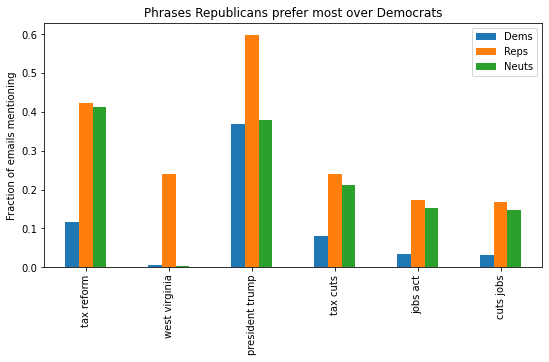

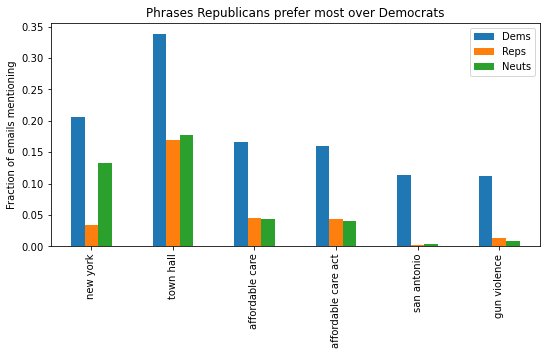

In [23]:
numOfEach = 6
dfrepoverdem = df.sort_values("RepFreq-DemFreq",ascending=False).filter(["Dems","Reps","Neuts"]).head(numOfEach)
dfrepoverdem.plot.bar()
plt.title("Phrases Republicans prefer most over Democrats")
plt.ylabel("Fraction of emails mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("RepOverDem.png",dpi=100)
plt.show()
dfdemoverrep = df.sort_values("RepFreq-DemFreq",ascending=True).filter(["Dems","Reps","Neuts"]).head(numOfEach)
dfdemoverrep.plot.bar()
plt.title("Phrases Republicans prefer most over Democrats")
plt.ylabel("Fraction of emails mentioning")
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.savefig("DemOverRep.png",dpi=100)
plt.show()